In [1]:
# Comparing Pagel's lambda with a convex combination of normals

In [20]:
import numpy as np
import matplotlib.pyplot as plt

from src.phylogenetic_signal import PagelsLambda


In [8]:
pl = PagelsLambda(tree="seedplants/tree.nwk", format=0)


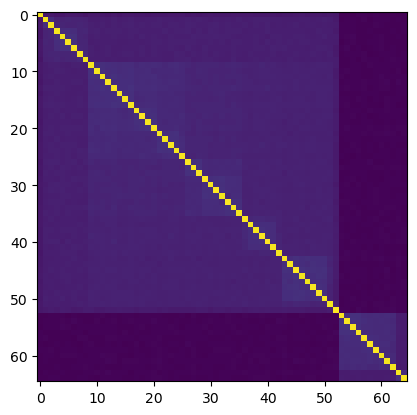

In [49]:
plt.imshow(np.cov(x, rowvar=False))

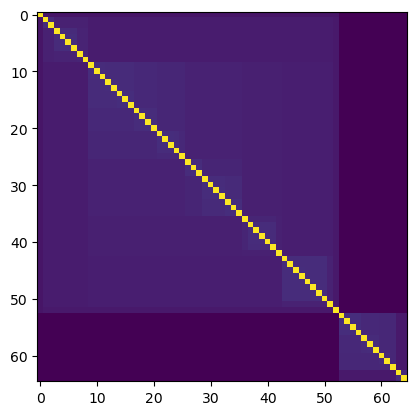

In [50]:
plt.imshow(C+C_zero)

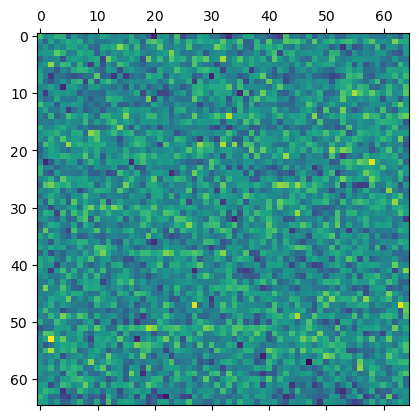

In [34]:
plt.matshow(x)

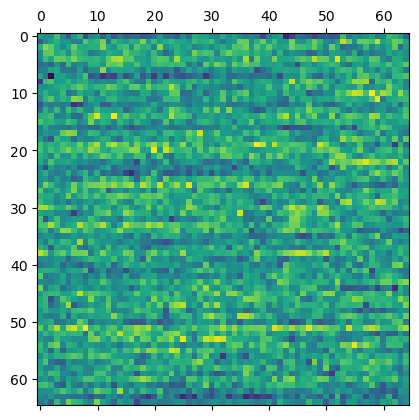

In [35]:
plt.matshow(x_half)

In [37]:
# Is C positive definite?
print(np.min(np.linalg.eigvals(C)))
# Must be positive

0.00010187403243875117
